# Analyse des votes des sénateurs

L'objectif de cette étude est d'inférer le positionnement idéal des sénateurs les uns par rapport aux autres en fonction de leurs votes.

Avant de réaliser cette étude une analyse préliminaire du jeu de données doit être réalisé.

1. Vérifier l'intégrité des données : vérifier que les données sont complètes, qu'il n'y a pas de valeurs manquantes ou aberrantes.

2. Résumer les données et les visualiser : calculer les statistiques descriptives telles que la moyenne, l'écart-type, les fréquences pour les variables catégorielles.

Une fois ces étapes réalisées, on peut passer à la partie relationnelle des variables.

3. Identifier les relations entre les variables : utiliser des tableaux de contingence, des croisements de variables et des matrices de corrélation pour identifier les relations entre les variables.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
df = pd.read_csv("data\\20230331_Data_Votes_Senateurs.csv", encoding='ISO-8859-1')
df

,scrutin_num,date_seance,senateur,vote
0,1,11 octobre 2022,Maurice Antiste,ont voté pour
1,1,11 octobre 2022,Thierry Cozic,ont voté pour
2,1,11 octobre 2022,Gisèle Jourda,ont voté pour
3,1,11 octobre 2022,Raymonde Poncet Monge,ont voté pour
4,1,11 octobre 2022,Cathy Apourceau-Poly,ont voté pour
...,...,...,...,...
89674,257,21 mars 2023,Jean Louis Masson,n'ont pas pris part au vote
89675,257,21 mars 2023,Valérie Létard,n'ont pas pris part au vote
89676,257,21 mars 2023,Fabien Gay,n'ont pas pris part au vote
89677,257,21 mars 2023,*,n'ont pas pris part au vote


In [3]:
df['senateur'].nunique()

350

Le résultat est étonnant car il n'y a que 348 sénateurs en exercice. Une analyse manuelle permet de déterminer que l'écart provient d'un " * " qui s'est glissé dans notre liste de députés et de l'apparition de "Philippe Nachbar" dans notre base ancien député démissionnaire.* 
Aucune autre coquille ne semble s'être glissée dans notre fichier. Nous avons donc décidé de nettoyer notre base en retirant l' " * " et en conservant "Philippe Nachbar".

*https://www.lemonde.fr/les-decodeurs/article/2023/01/10/frais-de-mandat-philippe-nachbar-ex-senateur-de-meurthe-et-moselle-condamne-pour-detournement-de-fonds-publics_6157334_4355770.html

In [4]:
df = df[~df['senateur'].str.contains('\*')]
df

,scrutin_num,date_seance,senateur,vote
0,1,11 octobre 2022,Maurice Antiste,ont voté pour
1,1,11 octobre 2022,Thierry Cozic,ont voté pour
2,1,11 octobre 2022,Gisèle Jourda,ont voté pour
3,1,11 octobre 2022,Raymonde Poncet Monge,ont voté pour
4,1,11 octobre 2022,Cathy Apourceau-Poly,ont voté pour
...,...,...,...,...
89673,257,21 mars 2023,Esther Benbassa,n'ont pas pris part au vote
89674,257,21 mars 2023,Jean Louis Masson,n'ont pas pris part au vote
89675,257,21 mars 2023,Valérie Létard,n'ont pas pris part au vote
89676,257,21 mars 2023,Fabien Gay,n'ont pas pris part au vote


Pour inférer la position des sénateurs français à l'aide d'un modèle de "spatial vote" à une dimension, nous allons :

1. Créer une matrice de votes où chaque ligne représente un sénateur et chaque colonne représente un vote sur une question spécifique.
2. Créer un modèle de type "idéologie latente", qui représente les positions politiques des sénateurs sur un axe unique.
3. Entraîner le modèle de "spatial vote" sur les données de vote en utilisant la méthode de maximisation de la vraisemblance (MLE) pour estimer les positions latentes des sénateurs.
4. Visualiser les positions des sénateurs sur un axe unique pour voir leur positionnement politique. Vous pouvez utiliser des bibliothèques de visualisation comme Matplotlib pour cela.

In [5]:
# Créer une matrice de votes en pivotant le tableau df
votes_matrix = pd.pivot_table(df, values='vote', index='senateur', columns='scrutin_num', aggfunc=lambda x: x)

# Remplacer les valeurs manquantes dans la matrice de votes par zéro
votes_matrix = votes_matrix.fillna(0)

# Afficher la matrice de votes
votes_matrix

scrutin_num,1,2,3,4,5,6,7,8,9,10,...,248,249,250,251,252,253,254,255,256,257
senateur,,,,,,,,,,,,,,,,,,,,,
Abdallah Hassani,ont voté contre,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,abstentions,ont voté pour,ont voté pour,...,ont voté contre,ont voté pour,ont voté pour,ont voté pour,abstentions,ont voté pour,ont voté pour,ont voté contre,ont voté pour,ont voté contre
Agnès Canayer,ont voté contre,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté pour,ont voté pour,...,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté contre,ont voté pour,ont voté contre,ont voté pour
Alain Cadec,ont voté contre,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté pour,ont voté pour,...,ont voté pour,abstentions,ont voté pour,abstentions,ont voté contre,ont voté contre,ont voté contre,ont voté pour,ont voté contre,ont voté pour
Alain Cazabonne,ont voté contre,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,abstentions,ont voté pour,ont voté pour,...,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté pour
Alain Chatillon,ont voté contre,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté pour,ont voté pour,...,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté contre,ont voté pour,ont voté contre,ont voté pour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Éric Jeansannetas,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté pour,ont voté contre,ont voté pour,ont voté contre,abstentions,...,abstentions,ont voté contre,ont voté pour,ont voté contre,abstentions,ont voté contre,ont voté contre,ont voté pour,ont voté contre,abstentions
Éric Kerrouche,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté pour,ont voté contre,ont voté pour,ont voté contre,abstentions,...,abstentions,ont voté contre,ont voté pour,ont voté contre,abstentions,ont voté contre,ont voté contre,ont voté contre,ont voté contre,abstentions
Étienne Blanc,ont voté contre,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté pour,ont voté pour,...,ont voté pour,ont voté pour,ont voté pour,ont voté pour,ont voté contre,ont voté contre,ont voté contre,ont voté pour,ont voté contre,ont voté pour


Réalisons une ACM

In [6]:
votes_matrix = votes_matrix.replace({'abstentions': 0, "n'ont pas pris part au vote": 0, 0: 0, 'ont voté contre': -1, 'ont voté pour': 1})
votes_matrix

scrutin_num,1,2,3,4,5,6,7,8,9,10,...,248,249,250,251,252,253,254,255,256,257
senateur,,,,,,,,,,,,,,,,,,,,,
Abdallah Hassani,-1,1,1,1,1,1,-1,0,1,1,...,-1,1,1,1,0,1,1,-1,1,-1
Agnès Canayer,-1,1,1,1,1,1,-1,-1,1,1,...,1,1,1,1,-1,-1,-1,1,-1,1
Alain Cadec,-1,1,1,1,1,1,-1,-1,1,1,...,1,0,1,0,-1,-1,-1,1,-1,1
Alain Cazabonne,-1,1,1,1,1,1,-1,0,1,1,...,1,1,1,1,-1,1,1,1,-1,1
Alain Chatillon,-1,1,1,1,1,1,-1,-1,1,1,...,1,1,1,1,-1,-1,-1,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Éric Jeansannetas,1,1,1,-1,-1,1,-1,1,-1,0,...,0,-1,1,-1,0,-1,-1,1,-1,0
Éric Kerrouche,1,1,1,-1,-1,1,-1,1,-1,0,...,0,-1,1,-1,0,-1,-1,-1,-1,0
Étienne Blanc,-1,1,1,1,1,1,-1,-1,1,1,...,1,1,1,1,-1,-1,-1,1,-1,1


In [7]:
# Créer une fonction lambda qui remplace les valeurs non souhaitées par 0
replace_func = lambda x: 0 if x not in [-1, 1] else x

# diviser chaque valeur non nulle de chaque colonne par le facteur de normalisation
normalize_func = lambda x: (x*(len(votes_matrix.index) / sum(x))-1) if sum(x) != 0 else x
votes_matrix_normalized = votes_matrix.applymap(replace_func).apply(normalize_func)
votes_matrix_normalized

scrutin_num,1,2,3,4,5,6,7,8,9,10,...,248,249,250,251,252,253,254,255,256,257
senateur,,,,,,,,,,,,,,,,,,,,,
Abdallah Hassani,1.342282,0.144262,0.246429,1.528986,1.566176,0.054381,0.017493,-1.000000,1.154321,0.407258,...,-2.80829,3.204819,0.017493,3.417722,-1.000000,-3.837398,-3.748031,-2.846561,-2.460251,-2.971751
Agnès Canayer,1.342282,0.144262,0.246429,1.528986,1.566176,0.054381,0.017493,9.575758,1.154321,0.407258,...,0.80829,3.204819,0.017493,3.417722,0.994286,1.837398,1.748031,0.846561,0.460251,0.971751
Alain Cadec,1.342282,0.144262,0.246429,1.528986,1.566176,0.054381,0.017493,9.575758,1.154321,0.407258,...,0.80829,-1.000000,0.017493,-1.000000,0.994286,1.837398,1.748031,0.846561,0.460251,0.971751
Alain Cazabonne,1.342282,0.144262,0.246429,1.528986,1.566176,0.054381,0.017493,-1.000000,1.154321,0.407258,...,0.80829,3.204819,0.017493,3.417722,0.994286,-3.837398,-3.748031,0.846561,0.460251,0.971751
Alain Chatillon,1.342282,0.144262,0.246429,1.528986,1.566176,0.054381,0.017493,9.575758,1.154321,0.407258,...,0.80829,3.204819,0.017493,3.417722,0.994286,1.837398,1.748031,0.846561,0.460251,0.971751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Éric Jeansannetas,-3.342282,0.144262,0.246429,-3.528986,-3.566176,0.054381,0.017493,-11.575758,-3.154321,-1.000000,...,-1.00000,-5.204819,0.017493,-5.417722,-1.000000,1.837398,1.748031,0.846561,0.460251,-1.000000
Éric Kerrouche,-3.342282,0.144262,0.246429,-3.528986,-3.566176,0.054381,0.017493,-11.575758,-3.154321,-1.000000,...,-1.00000,-5.204819,0.017493,-5.417722,-1.000000,1.837398,1.748031,-2.846561,0.460251,-1.000000
Étienne Blanc,1.342282,0.144262,0.246429,1.528986,1.566176,0.054381,0.017493,9.575758,1.154321,0.407258,...,0.80829,3.204819,0.017493,3.417722,0.994286,1.837398,1.748031,0.846561,0.460251,0.971751


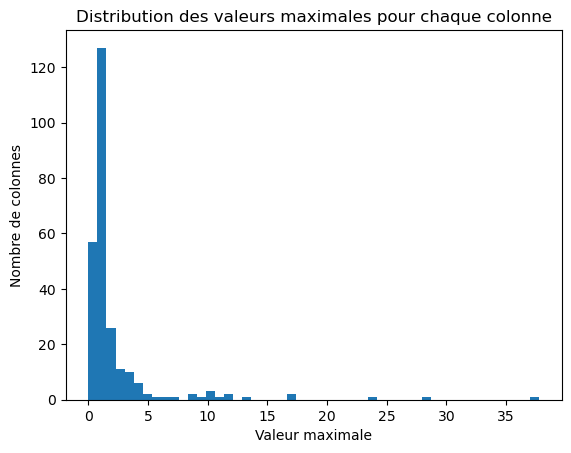

In [8]:
# Trouver les valeurs maximales pour chaque colonne
max_values = votes_matrix_normalized.max()

# Créer un histogramme de la distribution des valeurs maximales
plt.hist(max_values, bins=50)
plt.xlabel('Valeur maximale')
plt.ylabel('Nombre de colonnes')
plt.title('Distribution des valeurs maximales pour chaque colonne')
plt.show()

In [9]:
# Trouver les colonnes où la valeur maximale est supérieure à 5
cols_to_drop = votes_matrix_normalized.columns[votes_matrix_normalized.max() > 5]

# Supprimer les colonnes du DataFrame
votes_matrix_normalized = votes_matrix_normalized.drop(cols_to_drop, axis=1)
votes_matrix_normalized.describe()

scrutin_num,1,2,3,4,5,6,7,9,10,11,...,248,249,250,251,252,253,254,255,256,257
count,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,...,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02
mean,-6.107817e-17,-1.526954e-17,1.526954e-17,4.071878e-17,8.143756e-17,-8.907233e-18,-7.507525e-17,-1.017970e-17,-2.035939e-17,4.071878e-17,...,3.053909e-17,2.035939e-17,-7.443902e-17,-6.107817e-17,-2.035939e-17,6.107817e-17,7.125787e-17,-1.017970e-17,7.634772e-18,-1.017970e-17
std,2.068445e+00,4.847431e-01,6.987203e-01,2.241723e+00,2.281211e+00,2.335314e-01,1.532740e-01,1.893378e+00,6.652614e-01,1.923614e+00,...,1.123225e+00,3.820286e+00,1.324499e-01,4.026669e+00,1.196425e+00,2.624122e+00,2.537775e+00,1.490217e+00,1.036491e+00,1.342111e+00
min,-3.342282e+00,-2.144262e+00,-2.246429e+00,-3.528986e+00,-3.566176e+00,-1.000000e+00,-2.017493e+00,-3.154321e+00,-2.407258e+00,-3.181250e+00,...,-2.808290e+00,-5.204819e+00,-1.000000e+00,-5.417722e+00,-2.994286e+00,-3.837398e+00,-3.748031e+00,-2.846561e+00,-2.460251e+00,-2.971751e+00
25%,-3.342282e+00,1.442623e-01,2.464286e-01,-3.528986e+00,-3.566176e+00,5.438066e-02,1.749271e-02,-3.154321e+00,-1.000000e+00,-3.181250e+00,...,-1.000000e+00,-5.204819e+00,1.749271e-02,-5.417722e+00,-1.000000e+00,-3.837398e+00,-3.748031e+00,-1.000000e+00,4.602510e-01,-1.000000e+00
50%,1.342282e+00,1.442623e-01,2.464286e-01,1.528986e+00,1.566176e+00,5.438066e-02,1.749271e-02,1.154321e+00,4.072581e-01,1.181250e+00,...,8.082902e-01,3.204819e+00,1.749271e-02,3.417722e+00,9.942857e-01,1.837398e+00,1.748031e+00,8.465608e-01,4.602510e-01,9.717514e-01
75%,1.342282e+00,1.442623e-01,2.464286e-01,1.528986e+00,1.566176e+00,5.438066e-02,1.749271e-02,1.154321e+00,4.072581e-01,1.181250e+00,...,8.082902e-01,3.204819e+00,1.749271e-02,3.417722e+00,9.942857e-01,1.837398e+00,1.748031e+00,8.465608e-01,4.602510e-01,9.717514e-01
max,1.342282e+00,1.442623e-01,2.464286e-01,1.528986e+00,1.566176e+00,5.438066e-02,1.749271e-02,1.154321e+00,4.072581e-01,1.181250e+00,...,8.082902e-01,3.204819e+00,1.749271e-02,3.417722e+00,9.942857e-01,1.837398e+00,1.748031e+00,8.465608e-01,4.602510e-01,9.717514e-01


In [10]:
# Créer un objet PCA avec 10 composantes
pca = PCA(n_components=10)

# Appliquer l'ACP sur la matrice de distance
dist_pca = pca.fit_transform(votes_matrix_normalized)

# Obtenir le pourcentage expliqué par chaque axe principal
variance_ratio = pca.explained_variance_ratio_

# Afficher le pourcentage expliqué par chaque axe principal
for i, ratio in enumerate(variance_ratio):
    print(f"Composante {i+1}: {ratio*100:.2f}%")

Composante 1: 77.82%
Composante 2: 8.31%
Composante 3: 3.40%
Composante 4: 2.08%
Composante 5: 1.68%
Composante 6: 0.85%
Composante 7: 0.77%
Composante 8: 0.55%
Composante 9: 0.42%
Composante 10: 0.42%


In [11]:
# Créer un objet PCA avec une seule dimension
pca = PCA(n_components=2)

# Appliquer l'ACP sur la matrice de distance
dist_pca = pca.fit_transform(votes_matrix_normalized)

# Convertir la matrice PCA en un DataFrame Pandas
dist_pca_df = pd.DataFrame(data=dist_pca, index=votes_matrix_normalized.index, columns=['Position 1', 'Position 2'])

# Afficher le DataFrame avec les positions des législateurs sur l'axe unidimensionnel
dist_pca_df

,Position 1,Position 2
senateur,,
Abdallah Hassani,-4.785121,29.505860
Agnès Canayer,-23.363325,-4.508493
Alain Cadec,-21.893254,-5.001910
Alain Cazabonne,-19.403632,-1.924677
Alain Chatillon,-23.363325,-4.508493
...,...,...
Éric Jeansannetas,47.616050,-3.305584
Éric Kerrouche,47.727041,-3.091102
Étienne Blanc,-20.506021,-5.604654


In [12]:
df_senateurs_roles = pd.read_csv("data\\20230415_Data_Senateurs_Roles_2.csv", encoding='ISO-8859-1', sep=";")
df_senateurs_roles["senateur"] = df_senateurs_roles.apply(lambda x: x["Prénom usuel"] + " " + x["Nom usuel"], axis=1)

dist_pca_df = pd.merge(dist_pca_df, df_senateurs_roles[['senateur', 'Groupe politique']], on='senateur', how='left')

# Sélectionnez les colonnes Position 1 et Position 2 de merged_df
X = dist_pca_df[['Position 1', 'Position 2']]

# Instancier un objet StandardScaler
scaler = StandardScaler()

# Centrer-réduire les données
X_scaled = scaler.fit_transform(X)

# Mettre à jour les colonnes Position 1 et Position 2 de merged_df avec les données centrées-réduites
dist_pca_df[['Position 1', 'Position 2']] = X_scaled

dist_pca_df.to_csv('data\\20230503_Data_ACP_Senateurs.csv')

dist_pca_df

,senateur,Position 1,Position 2,Groupe politique
0,Abdallah Hassani,-0.162573,3.068423,RDPI
1,Agnès Canayer,-0.793763,-0.468855,Les Républicains
2,Alain Cadec,-0.743817,-0.520167,Les Républicains
3,Alain Cazabonne,-0.659233,-0.200154,UC
4,Alain Chatillon,-0.793763,-0.468855,Les Républicains
...,...,...,...,...
344,Éric Jeansannetas,1.617742,-0.343760,SER
345,Éric Kerrouche,1.621513,-0.321455,SER
346,Étienne Blanc,-0.696686,-0.582849,Les Républicains
347,Évelyne Perrot,-0.681858,-0.156375,UC


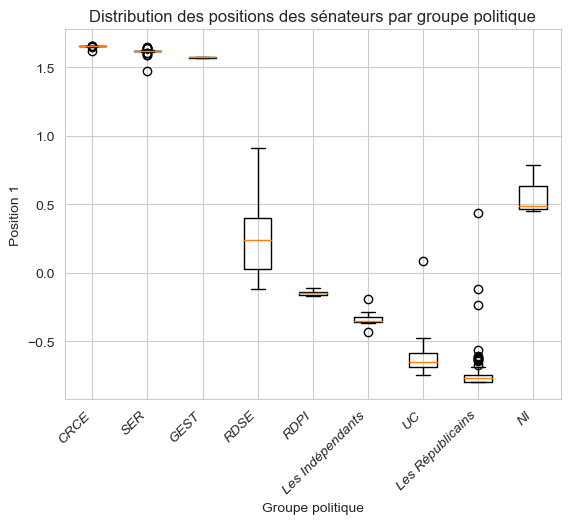

In [13]:
sns.set_style("whitegrid")

# Définir l'ordre des groupes politiques en fonction de leur place dans l'émicycle
ordre_groupes = ['CRCE', 'SER', 'GEST', 'RDSE', 'RDPI','Les Indépendants','UC','Les Républicains', 'NI']

# Réorganisation des données selon l'ordre souhaité
dist_pca_df = dist_pca_df.reset_index().set_index("Groupe politique").loc[ordre_groupes]

# Création d'une liste contenant les positions pour chaque groupe politique
positions_par_groupe = [dist_pca_df.loc[g]["Position 1"].values for g in ordre_groupes]

# Création du graphique en boîte à moustaches
fig, ax = plt.subplots()
ax.boxplot(positions_par_groupe)

# Ajout des labels et du titre
ax.set_xticklabels(ordre_groupes, rotation=45, ha='right', fontdict={'fontstyle': 'oblique'})
ax.set_xlabel("Groupe politique")
ax.set_ylabel("Position 1")
ax.set_title("Distribution des positions des sénateurs par groupe politique")

# Affichage du graphique
plt.show()

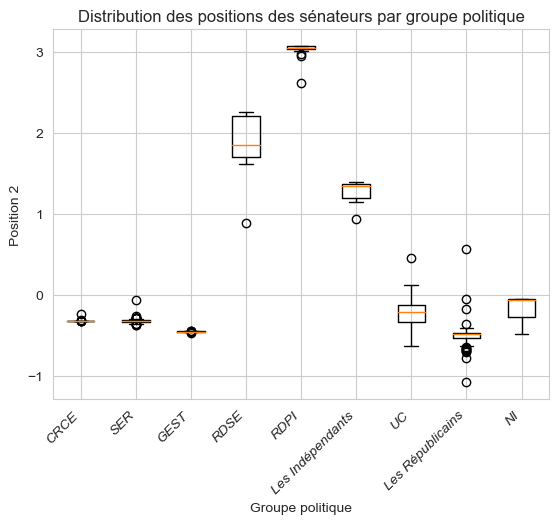

In [14]:
sns.set_style("whitegrid")

# Définir l'ordre des groupes politiques en fonction de leur place dans l'émicycle
ordre_groupes = ['CRCE', 'SER', 'GEST', 'RDSE', 'RDPI','Les Indépendants','UC','Les Républicains', 'NI']

# Réorganisation des données selon l'ordre souhaité
dist_pca_df = dist_pca_df.reset_index().set_index("Groupe politique").loc[ordre_groupes]

# Création d'une liste contenant les positions pour chaque groupe politique
positions_par_groupe = [dist_pca_df.loc[g]["Position 2"].values for g in ordre_groupes]

# Création du graphique en boîte à moustaches
fig, ax = plt.subplots()
ax.boxplot(positions_par_groupe)

# Ajout des labels et du titre
ax.set_xticklabels(ordre_groupes, rotation=45, ha='right', fontdict={'fontstyle': 'oblique'})
ax.set_xlabel("Groupe politique")
ax.set_ylabel("Position 2")
ax.set_title("Distribution des positions des sénateurs par groupe politique")

# Affichage du graphique
plt.show()


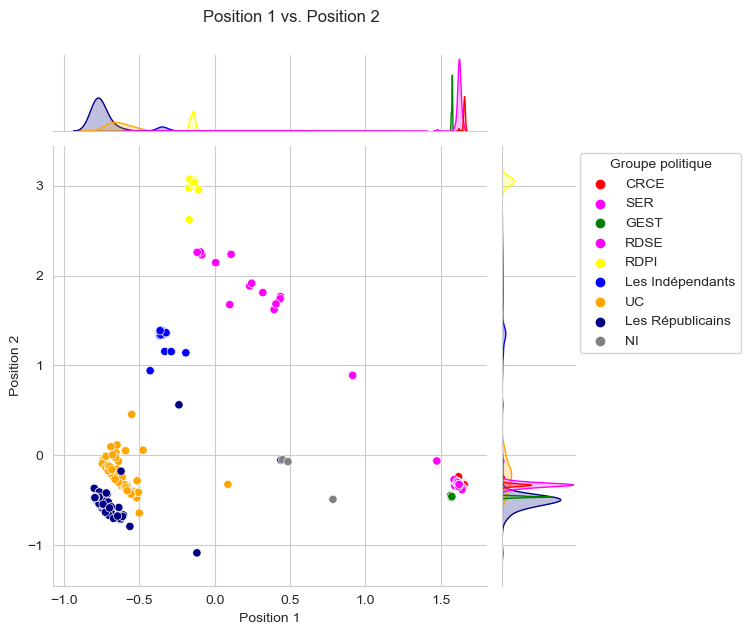

In [16]:
colors = {
    'CRCE': 'red',
    'SER': 'magenta',
    'GEST': 'green',
    'RDSE': 'magenta',
    'UC': 'orange',
    'RDPI': 'yellow',
    'Les Indépendants': 'blue',
    'Les Républicains': 'navy',
    'NI': 'grey'
}

# Créer un scatterplot avec une distribution marginale pour chaque variable
g = sns.jointplot(data=dist_pca_df, x='Position 1', y='Position 2', hue='Groupe politique', palette=colors)

# Modifier la légende et le titre
g.ax_joint.legend(title='Groupe politique', loc='upper left', bbox_to_anchor=(1.2, 1))
g.fig.suptitle('Position 1 vs. Position 2', y=1.05)

# Afficher le graphique
plt.show()

NI : 
Esther BENBASSA EELV jusqu'en 2021
Jean Louis MASSON ancien RPR UMP jusqu'en 2003 puis soutien de MLP en 2022
Stéphane RAVIER soutien d'Eric Zemmour en 2022

https://www.senat.fr/

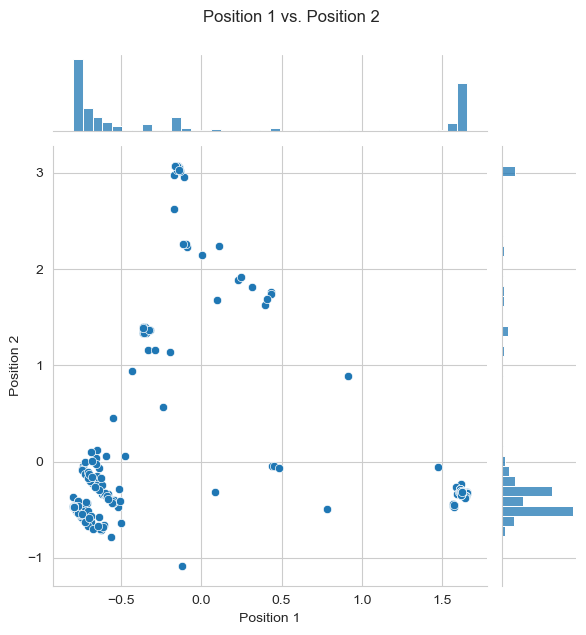

In [17]:
# Créer un scatterplot avec une distribution marginale pour chaque variable
g = sns.jointplot(data=dist_pca_df, x='Position 1', y='Position 2', marginal_kws=dict(bins=40))

# Modifier la légende et le titre
g.fig.suptitle('Position 1 vs. Position 2', y=1.05)

# Afficher le graphique
plt.show()